In [1]:
using Graphs
using MetaGraphs

using Graphs: SimpleDiGraph


In [2]:
struct LocalDAG
    g::SimpleDiGraph
end

function LocalDAG(
        input_size,
        output_size,
        num_hidden,
        window_size
    )
    num_nodes = (num_hidden + 1)*input_size + output_size
    g = SimpleDiGraph(num_nodes)
    
    
    return LocalDAG(g)
end

LocalDAG

In [3]:
ld = LocalDAG(5, 1, 3, 2)

LocalDAG({21, 0} directed simple Int64 graph)

In [4273]:
#TODO
#consider Ref(Vector{Float64})

#TODO
#consider only using BinaryNaturalFunction. This would double the number of parameters
# but simplify the learning rule and make everything more consistent

struct BinaryFunction
    weights::Vector{Ref{Float64}}
    bin_to_dec::Function
    threshold::Function
    function BinaryFunction(weights)
        function bin_to_dec(x)
            return sum([x[end-i]*2^i for i in 0:(length(x)-1)])
        end

        function threshold(x)
            return (x < 0) ? 0 : 1
        end
        new(weights, bin_to_dec, threshold)
    end
end

function (m::BinaryFunction)(x)
    weight = m.weights[m.bin_to_dec(x) + 1]
    return m.threshold(weight[]), weight
end

In [4274]:
struct RestrictedBinaryFunction
    weights::Vector{Ref{Float64}}
    bin_to_dec::Function
    function RestrictedBinaryFunction(weights)
        function bin_to_dec(x)
            return sum([x[end-i]*2^i for i in 0:(length(x)-1)])
        end

        new(weights, bin_to_dec, threshold)
    end
end

function (m::RestrictedBinaryFunction)(x)
    weight = m.weights[m.bin_to_dec(x) + 1]
    if weight == max([w for w in m.weights])
        return 1
    else 
        return 0
    end
end

In [4275]:
struct BinaryNaturalFunction
    weights::Matrix{Ref{Float64}}
    bin_to_dec::Function
    function BinaryNaturalFunction(weights)
        function bin_to_dec(x)
            return sum([x[end-i]*2^i for i in 0:(length(x)-1)])
        end
        new(weights, bin_to_dec)
    end
end

function (m::BinaryNaturalFunction)(x)
    weights = m.weights[m.bin_to_dec(x) + 1, :]
    
    max_index = argmax([w[] for w in weights])
    
    return max_index-1, weights[max_index]
end

In [4276]:
#TODO
# Think about how the learning method effects the binary natural function
# compared to the binary function

# Test out the binary restricted function in the hidden layers

# Update to include new variables: 
    # A vector of vector of vectors window_blueprint where the size of the first vector
    # is the number of hidden layers, the size of the inner vector is
    # the number of nodes in the hidden layer, and the size of the inner inner vector 
    # is the size of the input for that node's hidden func. Each entry in the inner
    # inner vector is an index into eval defining the functions binary input.

    # Change hidden_funcs to a vector of vectors where the sizes correspond
    # to the above description and the inner vector contains
    # each node's hidden func

    # Change eval to a vector of vectors where the sizes correspond to above
    # above description and the inner vector contains the output of the
    # binary function contained in that node

    # Move window_size and window_center to one of the helper
    # methods which will now construct the old version by constructing
    # and passing the appropriate window_blueprint to the new struct

struct LocalBinaryNN
    eval::Matrix{Bool}
    hidden_funcs::Matrix{BinaryFunction}
    output_func::BinaryNaturalFunction
    input_size::Int64
    num_hidden::Int64
    window_size::Int64
    window_center::Int64
    output_sample::Vector{Int64}
    utilized_hidden_weights::Vector{Ref{Float64}}
    utilized_output_weights::Vector{Ref{Float64}}
end

function LocalBinaryNN(
        input_size,
        output_size,
        num_hidden,
        window_size,
        window_center,
        output_sample_size,
        batch_size
    )
    matrix_size = (num_hidden + 1, input_size)
    
    eval = zeros(Bool, matrix_size)
    
    # Broadcast piping ensures the random vectors are different
    hidden_funcs = [BinaryFunction((.1 * randn() + 5) .* rand([-1, 1], 2^window_size)) for i in 1:num_hidden, j in 1:input_size] 
    output_func = BinaryNaturalFunction(5.0 .* randn(2^output_sample_size, output_size) .+ 100)
    output_sample = rand(1:input_size, output_sample_size)
    
    utilized_hidden_weights = zeros(batch_size*(num_hidden*input_size))
    utilized_output_weights = zeros(batch_size)
    
    
    return LocalBinaryNN(
                    eval, 
                    hidden_funcs, 
                    output_func, 
                    input_size, 
                    num_hidden, 
                    window_size, 
                    window_center, 
                    output_sample,
                    utilized_hidden_weights,
                    utilized_output_weights
            )
end

function (m::LocalBinaryNN)(x, batch)
    m.eval[1, :] = x

    function index_wrap(ind, last)
        if (ind >= 1) && (ind <= last)
            return ind
        elseif (ind <= 0)
            return last + ind
        else
            return ind - last
        end
    end
    
    utilized_index = 0
    utilized_index_start = ((batch - 1)*(m.num_hidden*m.input_size) + 1)
    for i in 1:m.num_hidden
        for j in 1:m.input_size
            window_indices = (1:m.window_size) .- m.window_center
            window = [m.eval[i, index_wrap(j + k, end)] for k in window_indices]
            m.eval[i + 1, j], m.utilized_hidden_weights[utilized_index_start + utilized_index] = m.hidden_funcs[i, j](window)
            
            utilized_index += 1
        end
    end
    
    output, m.utilized_output_weights[batch] = m.output_func(m.eval[end, m.output_sample])
    
    return output
    
end

In [5163]:
input_size = 784
output_size = 10
num_hidden = 0
window_size = 3
window_center = 2
output_sample_size = 10
batch_size = 1

nn = LocalBinaryNN(
        input_size,
        output_size,
        num_hidden,
        window_size,
        window_center,
        output_sample_size,
        batch_size
    )

LocalBinaryNN(Bool[0 0 … 0 0], Matrix{BinaryFunction}(undef, 0, 784), BinaryNaturalFunction(Ref{Float64}[Base.RefValue{Float64}(103.63961576454147) Base.RefValue{Float64}(108.04033992629127) … Base.RefValue{Float64}(89.27941856976506) Base.RefValue{Float64}(99.25739379741913); Base.RefValue{Float64}(99.08526638523924) Base.RefValue{Float64}(91.31512363928127) … Base.RefValue{Float64}(95.74980689930491) Base.RefValue{Float64}(99.9151404119816); … ; Base.RefValue{Float64}(103.9242178987059) Base.RefValue{Float64}(97.29573525316708) … Base.RefValue{Float64}(99.3054185214969) Base.RefValue{Float64}(96.2900891178346); Base.RefValue{Float64}(102.39792205385754) Base.RefValue{Float64}(93.28757681815325) … Base.RefValue{Float64}(98.18258916714127) Base.RefValue{Float64}(94.5605085118505)], var"#bin_to_dec#2299"()), 784, 0, 3, 2, [393, 191, 210, 149, 633, 38, 2, 668, 460, 598], Ref{Float64}[], Ref{Float64}[Base.RefValue{Float64}(0.0)])

In [5164]:
# Finds the indices of unique elements in an array
function uniqueidx(x::AbstractArray{T}) where T
    ex = eachindex(x)
    idxs = Dict{Base.RefValue{Float64}, Vector{eltype(ex)}}()
    
    for i in ex
        xi = x[i]
        if !(xi in keys(idxs))
            idxs[xi] = [i]
        else
            append!(idxs[xi], i)
        end
    end
    idxs
end

uniqueidx (generic function with 1 method)

In [5165]:
using MLDatasets
using Flux
using Plots
using Random
using StatsBase: sample, mean

In [5166]:
# Warning: Currently finding weight by value. 
# If any weight is the same value, this will not work
function update!(utilized_hidden_weights::Vector{Ref{Float64}}, utilized_output_weights::Vector{Ref{Float64}}, hidden_epsilon::Vector{Float64}, output_epsilon::Vector{Float64}, flr::Float64)
    unique_hidden_weight_indices = uniqueidx(utilized_hidden_weights)
    unique_output_weight_indices = uniqueidx(utilized_output_weights)

    for (weight, indices) in unique_hidden_weight_indices
        eps = sum(hidden_epsilon[indices])
        
        weight_sign = sign(weight[])
        
        # TODO clip appropriately so that it takes some max number of
        # updates to flip
        weight[] = (0.01 * randn() + 1) * clamp(weight_sign*(abs(weight[]) + eps), -100*flr, 100*flr)
        #weight[] = weight_sign*(abs(weight[]) + eps)
    end
    
    #TODO
    #Determine epsilon based on the ratio of positives to negatives
    #of weight i to the ratio for all other weights
    #for (weight, indices in unique_output_weight_indices)
    #    output_epsilon[indices]
    #end
    
    for (weight, indices) in unique_output_weight_indices
        eps = sum(output_epsilon[indices])
        
        weight[] = weight[] + eps
    end
end

#function update!(utilized_weights::Vector{Ref{Float64}}, epsilon_mean::Float64, epsilon_variance::Float64)
#    epsilon = epsilon_variance.*randn(length(utilized_weights)) .+ epsilon_mean
#    update!(utilized_weights, epsilon)
#
#end

update! (generic function with 4 methods)

In [5167]:
# load full training set
train_x, train_y = MNIST.traindata();

function binary_label(num)
    if num == 0
        return 1
    else
        return 0
    end
end

train_x_vec = [Int.(round.(vec(train_x[:, :, i]))) for i = 1:60000];
#train_y_hot = [train_y[i] for i = 1:60000];
train_y_bin = [binary_label(train_y[i]) for i = 1:60000];

# load full test set
test_x,  test_y  = MNIST.testdata();

test_x_vec = [Int.(round.(vec(test_x[:, :, i]))) for i = 1:10000];
#test_y_hot = [onehot(test_y[i], 0:9) for i = 1:10000];
test_y_bin = [binary_label(test_y[i]) for i = 1:10000];

traindata = [(train_x_vec[i], train_y[i]) for i = 1:60000];
testdata = [(test_x_vec[i], test_y[i]) for i = 1:10000];

In [5168]:
train_sample_size = 2000
test_sample_size = 500
train_sample = sample(traindata, train_sample_size, replace=false);
test_sample = sample(testdata, test_sample_size, replace=false);

#train_sample = shuffle([
#                        shuffle(traindata[train_y_bin .== 1])[1:Int(train_sample_size/2)]; 
#                        shuffle(traindata[train_y_bin .== 0])[1:Int(train_sample_size/2)]
#                       ]);
#test_sample = shuffle([
#                        shuffle(testdata[test_y_bin .== 1])[1:Int(test_sample_size/2)]; 
#                        shuffle(testdata[test_y_bin .== 0])[1:Int(test_sample_size/2)]
#                      ]);

true_accuracy = 0.1

0.1

In [5216]:
data_batches = Flux.DataLoader(train_sample, batchsize=batch_size, shuffle=true)

num_batch_utilized_weights = (num_hidden*input_size)
num_hidden_utilized_weights = length(nn.utilized_hidden_weights)
num_output_utilized_weights = length(nn.utilized_output_weights)
hidden_weights_change = zeros(num_hidden_utilized_weights)
output_weights_change = zeros(num_output_utilized_weights)
accuracy = true_accuracy
its = Int(round(.1*train_sample_size))
rlr = 1
hidden_flr = 1
output_flr = 1
for data_batch in data_batches
    for batch_num in 1:batch_size
        d = data_batch[batch_num]
        
        utilized_index_start = ((batch_num - 1)*(num_hidden*input_size) + 1)
        
        guess = nn(d[1], batch_num);
        
        utilized_weight_indices = utilized_index_start:(utilized_index_start + num_batch_utilized_weights - 1)
        
        # want this to hold: flr / (flr + rlr) = accuracy
        # solving for flr we find
        # flr = accuracy * rlr / (1 - accuracy)
        # since accuracy = right/(right + wrong), we get
        # flr = right * rlr / wrong
        # I think it will be more stable to use the accuracy equation
        hidden_accuracy_percentage = 0.75
        output_accuracy_percentage = 0.75
        hidden_flr = (hidden_accuracy_percentage*accuracy) * rlr / (1 - hidden_accuracy_percentage*accuracy)
        output_flr = (output_accuracy_percentage*accuracy) * rlr / (1 - output_accuracy_percentage*accuracy)
        if guess == d[2]
            accuracy = (its * accuracy + 1) / (its + 1)
            hidden_weights_change[utilized_weight_indices] = (0.1*rlr) .* randn(num_batch_utilized_weights) .+ rlr
            output_weights_change[batch_num] = (0.1*rlr) .* randn() .+ rlr
        else
            
            accuracy = (its * accuracy) / (its + 1)
            hidden_weights_change[utilized_weight_indices] = (0.1*hidden_flr) .* randn(num_batch_utilized_weights) .+ -hidden_flr
            output_weights_change[batch_num] = (0.1*output_flr) .* randn() .+ -output_flr
        end

        its += 1
    end
    #println("weights: ", nn.output_func.weights)
    #println("utilized: ", nn.utilized_output_weights)
    update!(nn.utilized_hidden_weights, nn.utilized_output_weights, hidden_weights_change, output_weights_change, hidden_flr)
    #println("utilized: ", nn.utilized_output_weights)
end
println("accuracy: ", accuracy)
true_accuracy = 0
for x in train_sample
    guess = nn(x[1], 1);
    #println(guess, x[2])
    
    if guess == x[2]
        true_accuracy += 1
    end
end
true_accuracy = true_accuracy/(length(train_sample))
println(true_accuracy)
println(length(train_sample))

accuracy: 0.33545454545454595
0.315
2000


In [5217]:
digit_accuracy = zeros(10)
digits = zeros(length(test_sample))
j = 1
for i = 1:10
    digit_inds = findall((==(i-1)), [x[2] for x in test_sample])
    for ind in digit_inds
        digits[j] = nn(test_sample[ind][1], 1)
        digit_accuracy[i] += (nn(test_sample[ind][1], 1) == test_sample[ind][2])
        j += 1
    end
    digit_accuracy[i] /= length(digit_inds)
end
println(unique(digits))
digit_accuracy

[1.0, 5.0, 8.0, 9.0, 0.0, 4.0, 3.0, 2.0, 7.0, 6.0]


10-element Vector{Float64}:
 0.41509433962264153
 0.5652173913043478
 0.21428571428571427
 0.34545454545454546
 0.4807692307692308
 0.1590909090909091
 0.25925925925925924
 0.06666666666666667
 0.23809523809523808
 0.20454545454545456

In [3508]:
i = 0
for x in train_sample
    guess = nn(x[1], 1);
    
    if guess == x[2]
        update!(nn.utilized_weights, 1.0, 1.0)
    else
        update!(nn.utilized_weights, -1.0, 0.1)
    end
    #println(i)
    i += 1
end

correct = zeros(Bool, sample_size)
for i in 1:sample_size
    x = train_sample[i]
    guess = nn(x[1], 1);
    
    if guess == x[2]
        correct[i] = 1
        #println(guess, train_y[i])
    end
end
println(sum(correct)/sample_size)
println(1-sum([x[2] for x in train_sample])/sample_size)

LoadError: type LocalBinaryNN has no field utilized_weights

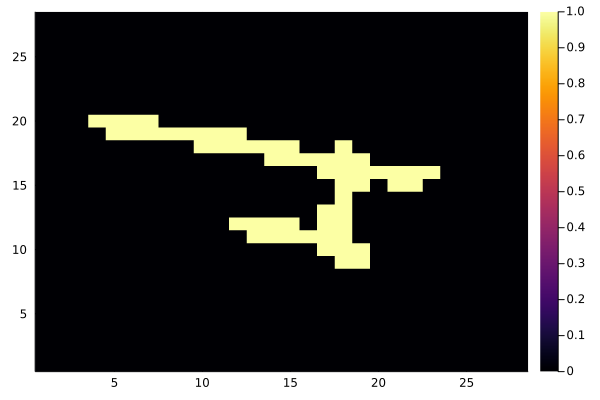

In [4353]:
gr()
heatmap(reshape(nn.eval[1, :], (28, 28)))

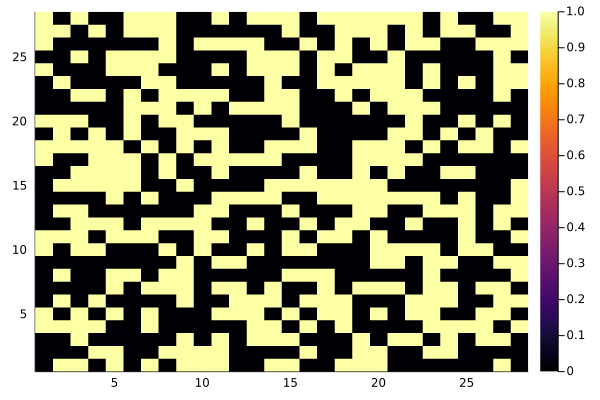

In [264]:
gr()
heatmap(reshape(rand(0:1, 784), (28, 28)))

In [4352]:
accuracy = 0
for x in test_sample
    guess = nn(x[1], 1);
    
    if guess == x[2]
        accuracy += 1
    end
end
println(accuracy/(length(test_sample)))
#println(1-sum([x[2] for x in test_sample])/test_sample_size)

0.444


In [163]:
input = rand(0:1, input_size);
nn(input)

1

In [116]:
update!(nn.utilized_weights, -5.0, 1)

-3.176497232447592
5.0558575972168605
-4.84134185667984
-2.5620881612784583
-4.363134976966799
-0.6886415685152851
-4.316231621787258
1.0358645472630126


In [117]:
nn.utilized_weights

4-element Vector{Ref{Float64}}:
 Base.RefValue{Float64}(1.8793603647692683)
 Base.RefValue{Float64}(2.2792536954013816)
 Base.RefValue{Float64}(3.6744934084515135)
 Base.RefValue{Float64}(-3.2803670745242455)

In [75]:
nn.hidden_funcs

1×3 Matrix{BinaryFunction}:
 BinaryFunction(Ref{Float64}[RefValue{Float64}(-0.352422), RefValue{Float64}(-0.366081), RefValue{Float64}(-0.478389), RefValue{Float64}(0.578417)], bin_to_dec, threshold)  …  BinaryFunction(Ref{Float64}[RefValue{Float64}(-0.386197), RefValue{Float64}(-0.519216), RefValue{Float64}(-0.68586), RefValue{Float64}(0.841628)], bin_to_dec, threshold)

In [229]:
nn.hidden_funcs[1, 1]

BinaryFunction([0.11982484290261623, 1.0925834452712107, 2.5467066690929916, -0.026714396966723307], var"#bin_to_dec#18"(), var"#threshold#20"())

In [223]:
nn.output_func.weights[1]

0.2896518863662988